In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel('Superstore.xls')
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [3]:
furniture = df.loc[df['Category']=='Furniture']
furniture['Order Date'].min()

Timestamp('2013-01-06 00:00:00')

In [4]:
furniture['Order Date'].max()

Timestamp('2016-12-30 00:00:00')

Data Processing:

This step includes removing columns we do not need , check missing values, aggregate sales by date and so on

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [6]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.head()

,Order Date,Sales
0,2013-01-06,2573.820
1,2013-01-07,76.728
2,2013-01-10,51.940
3,2013-01-11,9.940
4,2013-01-13,879.939


Indexing with Time series data

In [8]:
furniture = furniture.set_index('Order Date')


In [9]:
furniture.index

DatetimeIndex(['2013-01-06', '2013-01-07', '2013-01-10', '2013-01-11',
               '2013-01-13', '2013-01-14', '2013-01-16', '2013-01-19',
               '2013-01-20', '2013-01-21',
               ...
               '2016-12-18', '2016-12-19', '2016-12-21', '2016-12-22',
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [10]:
furniture.head()

,Sales
Order Date,
2013-01-06,2573.820
2013-01-07,76.728
2013-01-10,51.940
2013-01-11,9.940
2013-01-13,879.939


In [11]:
y = furniture['Sales'].resample('MS').mean()

In [12]:
y['2016':]

Order Date
2016-01-01     397.602133
2016-02-01     528.179800
2016-03-01     544.672240
2016-04-01     453.297905
2016-05-01     678.302328
2016-06-01     826.460291
2016-07-01     562.524857
2016-08-01     857.881889
2016-09-01    1209.508583
2016-10-01     875.362728
2016-11-01    1277.817759
2016-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

Visualizing furniture sales time series data

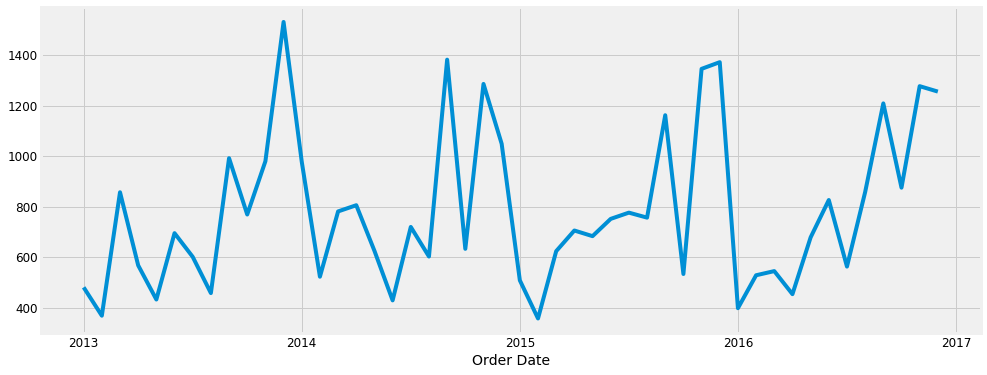

In [13]:
y.plot(figsize=(15,6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

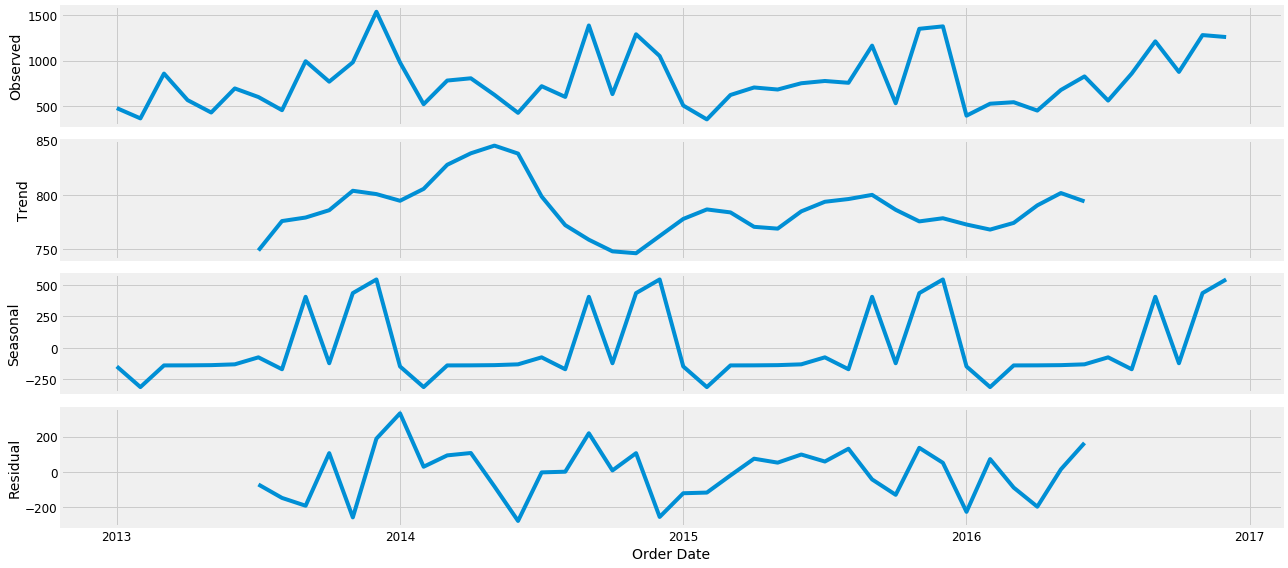

In [14]:
from pylab import rcParams
rcParams['figure.figsize']=18,8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()


The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [15]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('Examples of parameter combinations for seasonal ARIMA.. ')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[3]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[4]} x {seasonal_pdq[4]}')

Examples of parameter combinations for seasonal ARIMA.. 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.1028329076864


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1706.7899979397357
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.3880661554051
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:496.941688492852


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1322.3019041056377
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:319.4769282249068
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:721.8054702525408
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2809.420515250984
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.2292493113578
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:498.5015256159289
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:265097.14141014504
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:321.4768010188459
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:679.8426756921882


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1489.8186652327713
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.39264018642643
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.71214734967083


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1259.8342092925166
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:321.3936311404286
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:650.8057227356725
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2771.953984196696
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.5749841482841
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.0900255270103
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2722.673544509249
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:308.5900472444534
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:694.0509358217613


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1355.3820172720632
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.1280776489843
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.59877058922245


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1395.0597163257303
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:305.532653951522
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:666.7655840930229


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2689.444618733124
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.2153661016491
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:481.6722694642278
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2578.4030423430645
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:305.0198767582909
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:672.8145653210245


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1081.3243590246498
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.9529645628843
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:476.30398856902985
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1693.2197406498585
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:303.4338528916971
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:650.3325731985892


C:\Users\Santhosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.16759184691625
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.4412488126901
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3801.9840067291734
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.4152113711626


In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054      0.318      0.017      0.987      -0.618       0.629
ma.L1         -1.0000      0.403     -2.480      0.013      -1.790      -0.210
ar.S.L12      -0.0219      0.039     -0.557      0.577      -0.099       0.055
sigma2      2.898e+04   1.39e-05   2.08e+09      0.000     2.9e+04     2.9e+04


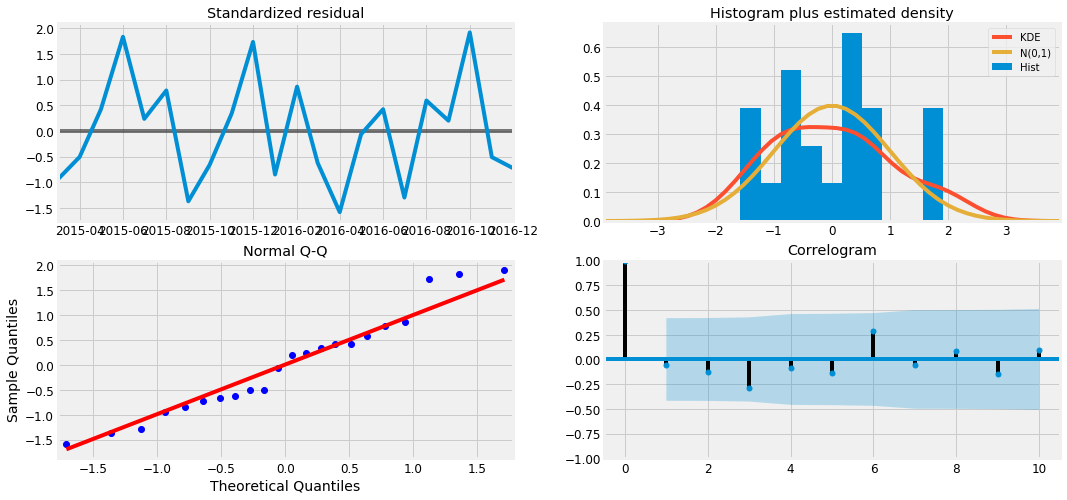

In [18]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

In [22]:
pred_ci

,lower Sales,upper Sales
2017-01-01,72.951517,750.483085


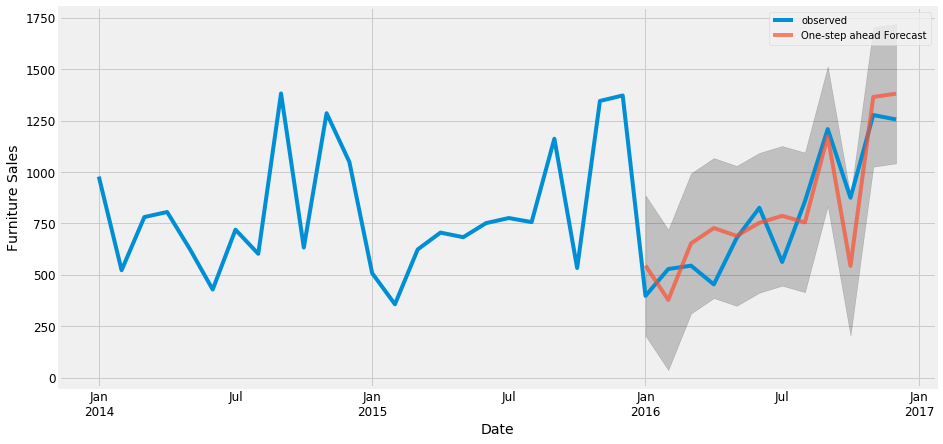

In [28]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [33]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27699.95


In [34]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 166.43


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

Producing and visualizing forecasts

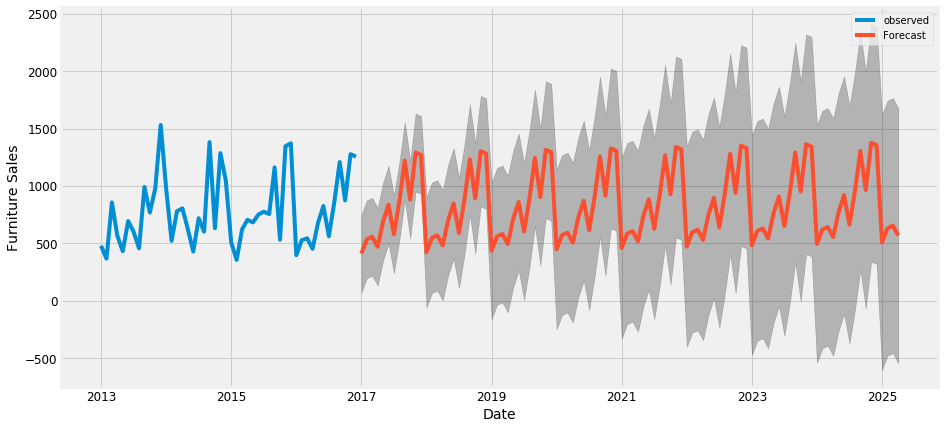

In [38]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of furniture and office supplier.

Time Series comparison furniture sales and Office Supplies


Data Preprocessing

In [40]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

In [41]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [42]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [43]:
furniture.head()

,Order Date,Sales
0,2013-01-06,2573.820
1,2013-01-07,76.728
2,2013-01-10,51.940
3,2013-01-11,9.940
4,2013-01-13,879.939


In [44]:
office.head()

,Order Date,Sales
0,2013-01-03,16.448
1,2013-01-04,288.060
2,2013-01-05,19.536
3,2013-01-06,685.340
4,2013-01-07,10.430


Data exploration

We are going to compare two categories' sales in the same time period. This means combine two data frames into one and plot these two categories' time series into one plot.

In [45]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2013-01-01,480.194231,285.357647
1,2013-02-01,367.931600,63.042588
2,2013-03-01,857.291529,391.176318
3,2013-04-01,567.488357,464.794750
4,2013-05-01,432.049187,324.346545


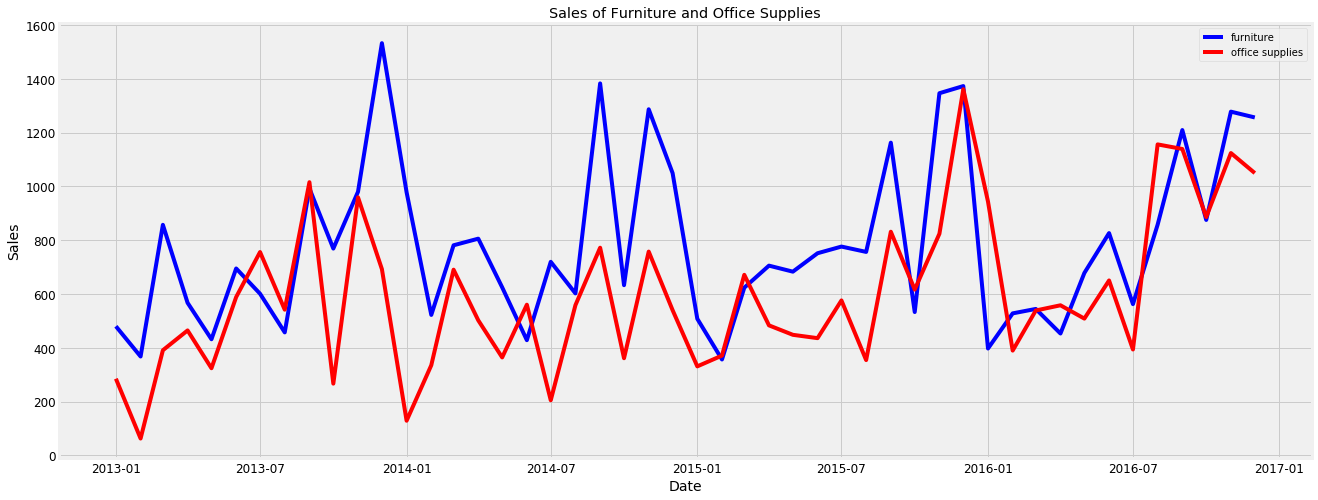

In [46]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [47]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2013-07-01.


Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [48]:
from fbprophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1296x432 with 0 Axes>

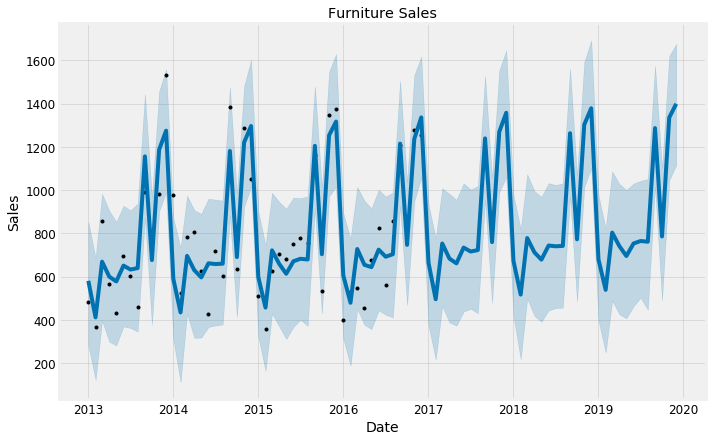

In [50]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

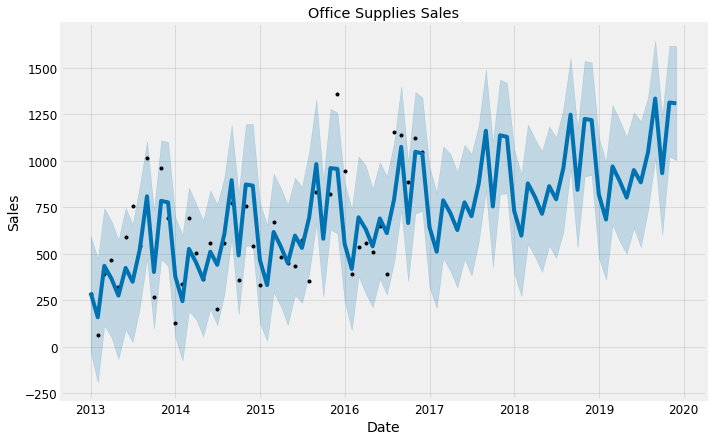

In [51]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

In [52]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2013-01-01,742.457737,280.950838,851.868310,742.457737,742.457737,-162.443756,-162.443756,-162.443756,-162.443756,...,-132.917058,-132.917058,-132.917058,-132.917058,-132.917058,-132.917058,0.0,0.0,0.0,291.851220
1,2013-02-01,744.326163,121.589130,686.293903,744.326163,744.326163,-333.481495,-333.481495,-333.481495,-333.481495,...,-273.155273,-273.155273,-273.155273,-273.155273,-273.155273,-273.155273,0.0,0.0,0.0,159.087446
2,2013-03-01,746.013774,396.195453,982.398191,746.013774,746.013774,-77.325870,-77.325870,-77.325870,-77.325870,...,-3.383494,-3.383494,-3.383494,-3.383494,-3.383494,-3.383494,0.0,0.0,0.0,435.610334
3,2013-04-01,747.882200,298.069707,904.174725,747.882200,747.882200,-148.795738,-148.795738,-148.795738,-148.795738,...,-79.679880,-79.679880,-79.679880,-79.679880,-79.679880,-79.679880,0.0,0.0,0.0,366.788389
4,2013-05-01,749.690220,281.722034,852.609772,749.690220,749.690220,-172.452356,-172.452356,-172.452356,-172.452356,...,-178.030388,-178.030388,-178.030388,-178.030388,-178.030388,-178.030388,0.0,0.0,0.0,275.671211


Visualizing the trend and the forecast¶

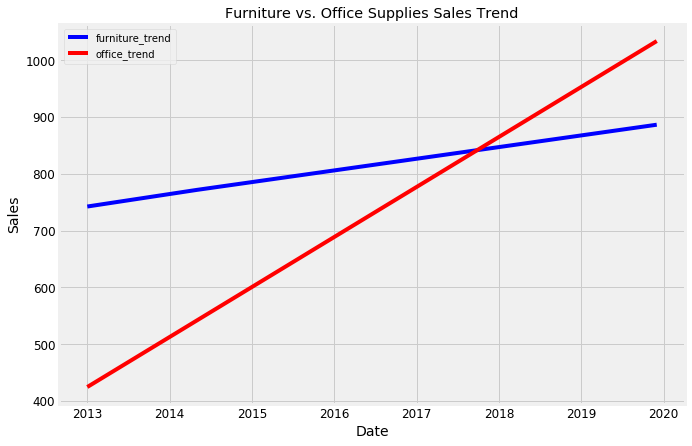

In [53]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

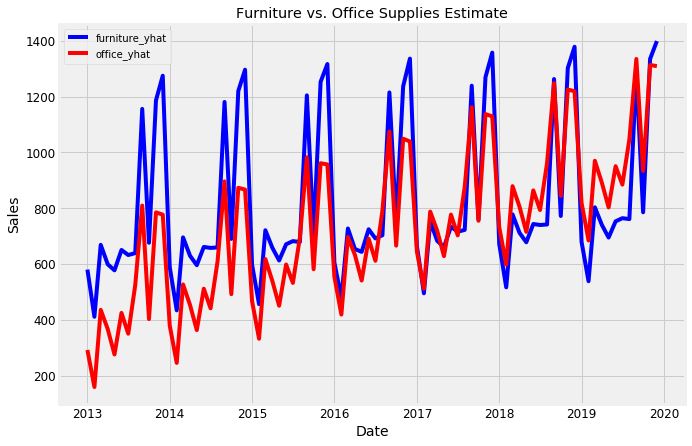

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

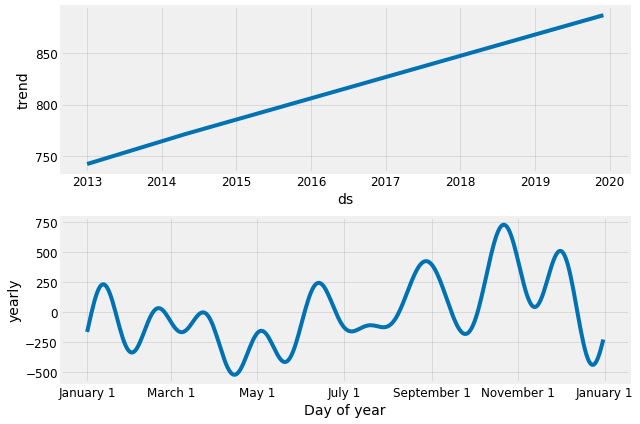

In [56]:
furniture_model.plot_components(furniture_forecast);

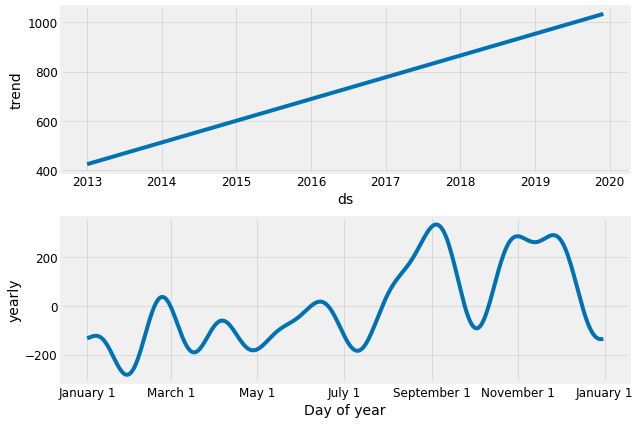

In [57]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time although office supplies' growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is November.

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only scratched the surface here. Stay tuned for future works on time-series analysis.